In [1]:
%reload_ext autoreload
%autoreload 2
import torch.nn as nn
from numpy import genfromtxt
import numpy as np
import torch
from deepc_hunt.dynamics import CartpoleDx, RocketDx
from deepc_hunt import DeePC, Trainer
from deepc_hunt.controllers import npDeePC, npMPC
from deepc_hunt.utils import tensor2np
from mpc import mpc
from mpc.mpc import QuadCost, GradMethods
import matplotlib.pyplot as plt
%matplotlib inline

### Data collection

In [2]:
# PRBS_inputs = [(0.33, -1, -0.5), (0.33, 0, -1), (0.75, -1, 1), (0.33, 0, 0.5), 
#  (0, -1, 0), (0.33, -1, 1), (0.75, 0, -0.5), (0.75, 0, -1), (0.75, -1, 0.5), (0, 0, 0), 
#   (0.75, 1, 0.5), (0, 0, -0.5), (0.33, 1, 0), (0.75, 0, 0), (0.33, 0, 1), (0, -1, 1), (0.75, -1, -1), 
#    (0, -1, 0.5), (0.75, 1, 1), (0.33, 1, -0.5), (0, 1, -0.5), (0.33, 0, 0), (0, 1, 1), (0.75, 1, -1), 
#     (0.33, 1, 1), (0.75, -1, -0.5), (0.75, 1, -0.5), (0, 0, 1), (0.75, 0, 1), (0.33, -1, 0.5), (0, -1, -1), 
#      (0, 1, 0), (0.33, 0, -0.5), (0.75, 0, 0.5), (0, 0, 0.5), (0.33, -1, 0), (0.75, 1, 0), (0.75, -1, 0), 
#       (0, 0, -1), (0, 1, -1), (0.33, 1, -1), (0, -1, -0.5), (0.33, -1, -1), (0.33, 1, 0.5), (0, 1, 0.5)]
# len(PRBS_inputs)

In [3]:
# import gymnasium as gym
# import numpy as np
# import itertools
# import random
# import coco_rocket_lander  # need to import to call gym.make()


# # initialize data collection
# # PRBS INPUT
# PRBS_inputs = [(0.33, -1, -0.5), (0.33, 0, -1), (0.75, -1, 1), (0.33, 0, 0.5), 
#  (0, -1, 0), (0.33, -1, 1), (0.75, 0, -0.5), (0.75, 0, -1), (0.75, -1, 0.5), (0, 0, 0), 
#   (0.75, 1, 0.5), (0, 0, -0.5), (0.33, 1, 0), (0.75, 0, 0), (0.33, 0, 1), (0, -1, 1), (0.75, -1, -1), 
#    (0, -1, 0.5), (0.75, 1, 1), (0.33, 1, -0.5), (0, 1, -0.5), (0.33, 0, 0), (0, 1, 1), (0.75, 1, -1), 
#     (0.33, 1, 1), (0.75, -1, -0.5), (0.75, 1, -0.5), (0, 0, 1), (0.75, 0, 1), (0.33, -1, 0.5), (0, -1, -1), 
#      (0, 1, 0), (0.33, 0, -0.5), (0.75, 0, 0.5), (0, 0, 0.5), (0.33, -1, 0), (0.75, 1, 0), (0.75, -1, 0), 
#       (0, 0, -1), (0, 1, -1), (0.33, 1, -1), (0, -1, -0.5), (0.33, -1, -1), (0.33, 1, 0.5), (0, 1, 0.5)]
      
# PRBS_interval = 5 # Number of frames per input

# ############### RANDOM INPUT GENERATOR ###############

# # set1 = (0, 0.33, 0.75)
# # set2 = (-1, 0, 1)
# # set3 = (-1, -0.5, 0,  0.5, 1)

# # PRBS_inputs = list(itertools.product(set1, set2, set3))
# # random.shuffle(PRBS_inputs)
# # print("Number of PRBS inputs is:", len(PRBS_inputs))
# # print("PRBS input combinations are:", PRBS_inputs)

# #######################################################

# n = 6 # states
# m = 3 # inputs
# p = 6 # outputs

# T_past = 1 # number of past measurements (also called T_ini)
# T_future = 10 # number of future measurements (also called K)

# L = T_past + T_future # length of a data sequence
# print("Length of a data sequence:", L)

# T_hankel =  PRBS_interval*len(PRBS_inputs) #(m*L + n) + L - 1 # number of measurements used to fill Hankel Matrix

# print("Number of measurements to fill Hankel Matrix:", T_hankel)

# rank_hankel_theoretical = m*L + n # theoretical maximum rank of Hankel Matrix
# print("Theoretical maximum rank of Hankel Matrix:", rank_hankel_theoretical)

# u_data = np.zeros((T_hankel,m))
# y_data = np.zeros((T_hankel,p))
# print("Shape of u_data:", np.shape(u_data))
# print("Shape of y_data:", np.shape(y_data))


# # make environment and wrap video so that we can replay them later

# args = {
#     "initial_position": (0.5, 0.4, 0)
# }

# env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args)
# env = gym.wrappers.RecordVideo(env, 'video', episode_trigger = lambda x: True, name_prefix="DeePC_Data_Collection")

# # simulate
# step_count = 0
# max_steps = T_hankel

# obs, info = env.reset(seed=0)  # specify a random seed for consistency

# while True:
#     landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]

#     # PRBS INPUT
#     action = np.array(PRBS_inputs[step_count//PRBS_interval])
#     # print("Used PRBS input number:", step_count//PRBS_interval)

#     # collect data
#     u_data[step_count] = action
#     y_data[step_count] = obs[0:6]

#     next_obs, rewards, done, _, info = env.step(action)

#     # check if simulation ended
#     step_count += 1
#     if done or (step_count >= max_steps):
#         break

#     # update observation
#     obs = next_obs


# env.close()  


### Initialise controller

In [4]:
# q = torch.Tensor([40,10,1,1,3000,30]) # 6-tuple (x, y, x_dot, y_dot, theta, theta_dot)
q = torch.Tensor([100,10,5,1,3000,30]) # 6-tuple (x, y, x_dot, y_dot, theta, theta_dot)
# q = torch.Tensor([10,1,1,1,1000,30]) # 6-tuple (x, y, x_dot, y_dot, theta, theta_dot)
# q = torch.Tensor([3,1,0.5,0.5,300,30]) # 6-tuple (x, y, x_dot, y_dot, theta, theta_dot)
r = torch.Tensor([0.01,0.01,0.01]) # 3-tuple (F_E, F_S, phi)
q_np = tensor2np(q)
r_np = tensor2np(r)

n = 6 # states
m = 3 # inputs
p = 6 # outputs

Tini = 1 # number of past measurements (also called T_ini)
Tf = 10 # number of future measurements (also called K)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_batch = 1

ud = np.genfromtxt('data/rocket_ud.csv', delimiter=',')
yd = np.genfromtxt('data/rocket_yd.csv', delimiter=',')

# y_constraints = np.ones(Tf*p)*1e5 #Unconstrained
# u_constraints = np.ones(Tf*m)
y_upper = np.kron(np.ones(Tf), np.array([33,26.6,100,100,0.6,100]))
y_lower = np.kron(np.ones(Tf), np.array([0,7,-100,-100,-0.6,-100]))
u_upper = np.kron(np.ones(Tf), np.array([1,1,1]))
u_lower = np.kron(np.ones(Tf), np.array([0,-1,-1]))
y_constraints = (y_lower, y_upper)
u_constraints = (u_lower, u_upper)
Trained = True


In [5]:
# For training
controller = DeePC(
    ud=ud, yd=yd, u_constraints=u_constraints, y_constraints=y_constraints,
    Tini=Tini, N=Tf, m=m, p=p, n_batch=n_batch, device=device,
    linear=False, stochastic_y=True, stochastic_u=False, q=q, r=r,
    # lam_g1=torch.Tensor([1e-5]), lam_g2=torch.Tensor([10]), lam_y=torch.Tensor([1e5])
).to(device)

epochs = 100
time_steps = 20
rocket = RocketDx(true_model=False)

225
length of constraints before noise : 7
length of constraints after noise : 9


In [4]:
# Tune regularization params
controller.initialise(lam_g1=50, lam_g2=50, lam_y=1000)
deepc_tuner = Trainer(controller=controller, env=rocket)
final_params = deepc_tuner.run(epochs=epochs, time_steps=time_steps)
Trained = True

  0%|                                                                       | 0/100 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/deepc-dev/lib/python3.10/site-packages/diffcp/cone_program.py:371: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")
/Users/michaelcummins/DeePC-HUNT/deepc_hunt/utils.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  Ct += (Y[i,j,:].T @ Q @ Y[i,j,:] + U[i,j,:].T @ R @ U[i,j,:]).reshape(1)


### Simulation results

In [6]:
# For speed
np_controller = npDeePC(
    ud=ud, yd=yd, u_constraints=u_constraints, y_constraints=y_constraints,
    Tini=Tini, N=Tf, m=m, p=p, n=n
)

np_controller.setup(Q=np.diag(q_np), R=np.diag(r_np), 
                    # lam_g1=tensor2np(final_params['lam_g1']), 
                    lam_g1=49.83,
                    # lam_g2=tensor2np(final_params['lam_g2']), 
                    lam_g2=8.364,
                    # lam_y=tensor2np(final_params['lam_y']))
                    lam_y=1000)

In [7]:
x_eq = np.array([16.6,7.47,0,0,0,0]) # Landing position
u_eq = np.array([0,0,0])
# u_eq = np.array([0,0,0])

A, B = rocket.linearise(x_eq=x_eq, u_eq=u_eq, discrete=True)
print("A:\n", A.round(3), "\n"*2, "B:\n", B.round(3))

mpc = npMPC(
        A=A, B=B, Q=np.diag(q_np), R=np.diag(r_np), N=Tf, 
        u_constraints=u_constraints, y_constraints=y_constraints
)
mpc.setup()

A:
 [[1.    0.    0.017 0.    0.    0.   ]
 [0.    1.    0.    0.017 0.    0.   ]
 [0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.017]
 [0.    0.    0.    0.    0.    1.   ]] 

 B:
 [[ 0.     0.     0.   ]
 [ 0.008  0.     0.   ]
 [ 0.     0.02   0.   ]
 [ 1.013  0.     0.   ]
 [ 0.    -0.     0.   ]
 [ 0.    -0.013  0.   ]]


In [29]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

import coco_rocket_lander  # need to import to call gym.make()
from coco_rocket_lander.env import SystemModel

args = {
    # "initial_position": (0.5, 0.6, 0),  # 3-tuple (x, y, theta)
    "initial_position": (0.6, 0.9, 0.1),  # 3-tuple (x, y, theta)
    # "random_initial_position" : True,
    # "initial_position": (np.random.uniform(low=0.2,high=0.8), np.random.uniform(low=0.7, high=0.9), np.random.uniform(low=-0.1, high=0.1)),
    "enable_wind": False,
    # "enable_moving_barge": True
}
vids = 1
data_driven = True
adaptive = False
root = 'DeePC' if data_driven else 'MPC'

# make environment and wrap video so that we can replay them later
env = gym.make("coco_rocket_lander/RocketLander-v0", render_mode="rgb_array", args=args)
env = gym.wrappers.RecordVideo(env, 'video/' + root, episode_trigger = lambda x: True, name_prefix=root)

model = SystemModel(env)
model.calculate_linear_system_matrices()
model.discretize_system_matrices(sample_time=0.1)


obs, info = env.reset()  # specify a random seed for consistency
# torch_state = torch.zeros((n_batch, 6))
# torch_state[:,:] = torch.Tensor(obs[:6]).unsqueeze(0)
# torch_state[1,0] = 16.3
# torch_state[0,0] = 18.3
# print(torch_state.shape)
# initialize variables
step_count = 0
max_steps = 1200
touched_ground = 0
landing_mode = 0
final_landing_position = []

# landing parameters
hover_height = 0
x_tol = 0.5
x_dot_tol = 0.3
theta_tol = 0.1
fig = []
#Initial state for DeePC
u_past_sim = np.zeros(3*Tini)
y_past_sim = np.tile(obs[0:6],Tini)

# u_past_sim = torch.zeros((n_batch, 3*Tini))
# y_past_sim = torch.zeros((n_batch, 6*Tini))
# y_past_sim[0,:] = torch.Tensor(y_past)
# y_past_sim[1,:] = torch.Tensor(y_past)

torch_states = []
real_states = []

# simulate
pbar = tqdm(range(max_steps))
for i in pbar:

    landing_position = env.get_landing_position()  # (x, y, theta) in [m, m, radians]
    deepc_reference = [0,0,0,0,0,0]
    deepc_reference[0] = landing_position[0]
    deepc_reference[1] = landing_position[1] + hover_height
    
    if landing_mode == 0: # default mode: try to hover above platform
      deepc_reference = [0,0,0,0,0,0]
      deepc_reference[0] = landing_position[0]
      deepc_reference[1] = landing_position[1] + hover_height
      if ((abs(obs[0]-landing_position[0]) < x_tol) and (abs(obs[2]) < x_dot_tol) and (abs(obs[4]) < theta_tol)): # if only small errors left, enter landing mode
        print("Enter landing mode")
        landing_mode = 1
        deepc_reference = [0,0,0,0,0,0]
        deepc_reference[0] = landing_position[0]
        deepc_reference[1] = landing_position[1]
        final_landing_position = deepc_reference.copy()
    elif landing_mode == 1: # landing mode: land at fixed position (works better when using moving barge)
      deepc_reference = final_landing_position.copy()

    deepc_reference = np.tile(deepc_reference,Tf)
    uref = np.zeros(m*Tf)
    # if landing_mode == 0:
    #   uref[::3] = rocket.g*rocket.mass/rocket.main_engine_thrust       

    # get action
    if((obs[6] and obs[7]) or touched_ground): # if both sensors touch the ground, stop
      action = [0,0,0]
      touched_ground = 1

    elif not touched_ground:
      if data_driven:
         action, _ = np_controller.solve(y_ref=deepc_reference, u_ref=uref, y_ini=y_past_sim[-p:], u_ini=u_past_sim)
      else:
         if adaptive:
          x_eq = y_past_sim[-p:]
          x_eq[2:] = 0
          u_eq = np.zeros(u_past_sim[-m:].shape)
          u_eq[0] = 0.3228
          mpc.A.value, mpc.B.value = rocket.linearise(x_eq=x_eq, u_eq=u_eq, discrete=True)
         action, _ = mpc.solve(y_ref=deepc_reference, u_ref=uref, y_ini=y_past_sim[-p:])
        # x_init = torch.Tensor(obs[:6]).unsqueeze(0)
        # assert x_init.ndimension() == 2
        # assert x_init.size(0) == 1
        # _,u,_ = diff_controller(x_init=torch.Tensor(obs), cost=diff_cost, dx=RocketDx())
        # action = tensor2np(u[0,:m])

    # store input & output for DeePC
    u_past_sim = np.append(u_past_sim[3:], action)
    y_past_sim = np.append(y_past_sim, obs[0:6])

    # # apply action
    fig.append(env.render())
    next_obs, rewards, done, _, info = env.step(action)
    obs = next_obs
    
    # check if simulation ended
    step_count += 1
    if done or (step_count > max_steps):
        # env.reset()
        # vids += 1
        # if vids == 2: break
       break
    
real_states = np.array(real_states)
torch_states = np.array(torch_states)
env.close()  # video saved at this step

/opt/homebrew/Caskroom/miniforge/base/envs/deepc-dev/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:79: UserWarning: WARN: Overwriting existing videos at /Users/michaelcummins/DeePC-HUNT/examples/video/MPC folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
 32%|███▏      | 378/1200 [00:04<00:08, 93.16it/s]

Moviepy - Building video /Users/michaelcummins/DeePC-HUNT/examples/video/MPC/MPC-episode-0.mp4.
Moviepy - Writing video /Users/michaelcummins/DeePC-HUNT/examples/video/MPC/MPC-episode-0.mp4



 32%|███▏      | 382/1200 [00:06<00:13, 61.54it/s]

Moviepy - Done !
Moviepy - video ready /Users/michaelcummins/DeePC-HUNT/examples/video/MPC/MPC-episode-0.mp4


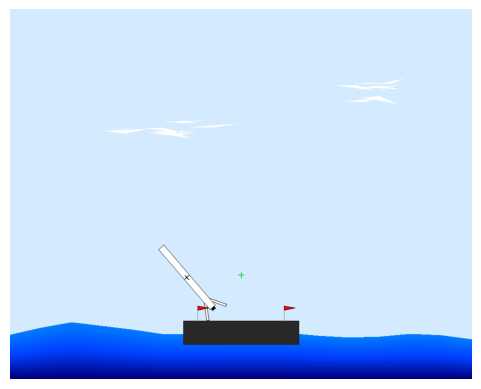

In [30]:
plt.imshow(fig[-1])
plt.axis('off')
if not data_driven:
    if rocket.true_model:
        plt.savefig('images/mpc/mpc_good.png') 
    else: 
        plt.savefig('images/mpc/mpc_bad.png')
else:
    if Trained:
        if rocket.true_model:
            plt.savefig('images/deepc/deepc_good.png') 
        else: 
            plt.savefig('images/deepc/deepc_bad.png')
    else: plt.savefig('images/deepc/rocket_untrained.png')
plt.show()

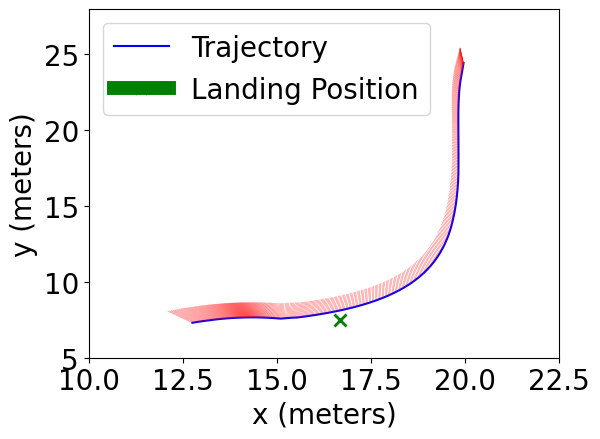

In [31]:
Trained = True
row = len(y_past_sim)/6
x_traj_deepc = y_past_sim.reshape(int(row),6)
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
plt.plot(x_traj_deepc[:,0], x_traj_deepc[:,1], c='blue', label='Trajectory')
for step in range(x_traj_deepc.shape[0]):
    plt.plot(
        [x_traj_deepc[step,0], x_traj_deepc[step,0]+np.sin(-x_traj_deepc[step,4])],
        [x_traj_deepc[step,1], x_traj_deepc[step,1]+np.cos(-x_traj_deepc[step,4])],
        c='red', linewidth=0.2
    )
plt.plot(landing_position[0], landing_position[1], c='green', marker='x', markersize=8, markeredgewidth=2, linewidth=10, label='Landing Position')
plt.legend(loc='upper left')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.xlim(10,22.5)
plt.ylim(5,28)
plt.tight_layout()
if not data_driven:
    if rocket.true_model:
        plt.savefig('images/mpc/mpc_good_traj.png') 
    else: 
        plt.savefig('images/mpc/mpc_bad_traj.png')
        # tikzplotlib.save('images/mpc/rocket_bad.tex')
else:
    if Trained:
        if rocket.true_model:
            print('saving')
            plt.savefig('images/deepc/deepc_good_traj.png') 
            # tikzplotlib.save('images/deepc/deepc_good_model_traj.tex') 
        else: 
            plt.savefig('images/deepc/deepc_bad_traj.png')
            # tikzplotlib.save('images/deepc/rocket_bad.tex')
    else: 
        plt.savefig('images/deepc/rocket_untrained_traj.png')
        # tikzplotlib.save('images/deepc/rocket_untrained.tex')
plt.show()